# Inference

Have a look into the predictions of a certain model on a specific orbit!

In [14]:
import constants as c
import harry_plotter
import models
import torch
import yaml

from tqdm import tqdm
from messenger_dataset import MessengerDataset
from utils import ioutils, torchutils

In [2]:
MODEL_RUN = 76
EPOCH = 28
ORBIT_ID = 42

Load model checkpoint and hyperparameters

In [6]:
run_path = ioutils.resolve_path(c.RUNS_DIR) / c.RUN_NAME(MODEL_RUN)
state_dict = torch.load(ioutils.resolve_path(run_path) / c.CKPT_SUBDIR / c.CKPT_FILE(EPOCH))
with open(run_path / c.HPARAMS_FILE) as f:
    HPARAMS = yaml.load(f, yaml.FullLoader)

Load the specified inference orbit

In [7]:
ds = MessengerDataset(ioutils.resolve_path(c.DATA_DIR),
                      features=HPARAMS["features"],
                      window_size=HPARAMS["window_size"],
                      future_size=HPARAMS["future_size"],
                      use_orbits=[ORBIT_ID])

Reconstruct the model

In [8]:
Arch = getattr(models, HPARAMS["model_arch"])
model = Arch(num_channels=len(HPARAMS["features"]),
             window_size=HPARAMS["window_size"],
             future_size=HPARAMS["future_size"],
             hidden_sizes=[HPARAMS[f"hidden_size{i}"] for i in range(HPARAMS["hidden_layers"])])
model.load_state_dict(state_dict)
model.eval()

print(f"trainable params: {torchutils.count_trainable_params(model)}")

trainable params: 126254


Put all window slices into one large batch

In [16]:
all_windows = torch.stack([sample for sample, label in tqdm(ds)])

100%|██████████| 43313/43313 [01:05<00:00, 661.22it/s]


Classify each time step in each of the windows

In [18]:
pred = model(all_windows)                   # predict class probabilities
pred = pred[:, :, :HPARAMS["window_size"]]  # discard future predictions
pred = pred.argmax(dim=1)                   # select the class with highest probability

Reduce predictions for each time step to a single one by majority voting

In [19]:
labels = torch.tensor([pred.flip([1]).diagonal(dim1=0, dim2=1, offset=i).mode().values
                       for i in range(pred.shape[1] - 1, -pred.shape[0], -1)])
print(labels.shape)

torch.Size([43432])


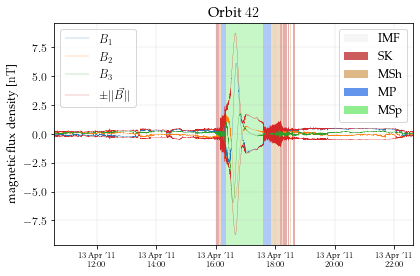

In [33]:
df_orbit = ds.get_orbits()[0]
figpath = str(ioutils.resolve_path(c.TEMP_DIR) / c.MESSENGER(ORBIT_ID)) + "_inference.pdf"
harry_plotter.plot_orbit(
    df_orbit.index,
    (df_orbit["BX_MSO"],
    df_orbit["BY_MSO"],
    df_orbit["BZ_MSO"]),
    symbol="B",
    labels=labels,
    title=f"Orbit ${ORBIT_ID}$",
    ylabel="magnetic flux density [\si{nT}]",
    outfile=figpath
)